In [102]:
import numpy as np
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
import time
import math
import pickle

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import shuffle

from sklearn import linear_model
from sklearn import ensemble

from sklearn import metrics

%matplotlib inline
pd.set_option('display.max_columns', None)

In [48]:
TRAIN_FILE = './data/phil-mickelson-strokes-train.csv'
TEST_FILE = './data/phil-mickelson-strokes-test.csv'

In [71]:
def load_and_process_data(file):
    df = pd.read_csv(file, index_col=None)
    
    df.drop(
        columns=['Player Name', 'Course Name', 'AM Wind Spd', 'AM Wind Dir', 'PM Wind Spd', 'PM Wind Dir'],
        axis=1,
        inplace=True
    )
    
    df.drop(
        columns=['Tee Grass', 'Fwy. Grass', 'Green Grass', 'Rough Grass', 'From Location(Enhanced)', 'To Location(Enhanced)'],
        axis=1,
        inplace=True
    )
    
    # year, tourn #, player #?, course #, round, hole, shot, time, one par, scorecard yrd, actual yrd, shot type, recovery shot
    df.drop(
        columns=['Tourn.#', 'Player #', 'Course #', 'Round', 'Hole', 'Shot', 'Time', 'Par', 'Scorecard Ydg', 'Actual Ydg', 'Shot Type(S/P/D)', 'Recovery Shot'],
        axis=1,
        inplace=True
    )
    
    #df = pd.get_dummies(df, 
    #                    prefix=['Shot_Type', 'Around_the_Green', '1st_Putt', 'Left_Right', 'Recovery_Shot'], 
    #                    columns=['Shot Type(S/P/D)', 'Around the Green Flag', '1st Putt Flag', 'Left/Right', 'Recovery Shot'])
    df = pd.get_dummies(df, 
                        prefix=['Around_the_Green', '1st_Putt', 'Left_Right'], 
                        columns=['Around the Green Flag', '1st Putt Flag', 'Left/Right'])
    
    encodings = {
        'Lie': {
            'Good': 1, 
            '0': -1, 
            'Unknown': -1, 
            'Buried': 2
        },
        'Elevation': {
            'With': 1, 
            'Below Ball': 2, 
            '0': -1, 
            'Unmapped': -1, 
            'Above Ball': 2, 
            'Unknown': -1
        },
        'Slope': {
            'Level': 1, 
            'Downhill': 2,
            '0': -1, 
            'Unknown': -1,
            'Uphill': 2
        },
        'Fwy Firmness': {
            'Medium': 1, 
            'Firm': 2, 
            'Soft': 0, 
            'Unknown': -1
        },
        'Grn Firmness': {
            'Soft': 0, 
            'Medium': 1, 
            'Firm': 2,
            'Unknown': -1
        },
        'From Location(Scorer)': {
            'Tee Box': 0, 
            'Fairway': 1, 
            'Fringe': 2, 
            'Green': 3, 
            'Intermediate Rough': 4, 
            'Primary Rough': 5, 
            'Green Side Bunker': 6, 
            'Fairway Bunker': 7, 
            'Native Area': 8, 
            '0': -1, 
            'Unknown': -1, 
            'Other': 9, 
            'Water': 10
        },
        'To Location(Scorer)': {
            'Tee Box': 0, 
            'Fairway': 1, 
            'Fringe': 2,
            'Green': 3, 
            'Intermediate Rough': 4, 
            'Primary Rough': 5, 
            'Green Side Bunker': 6, 
            'Fairway Bunker': 7,
            'Waste Bunker': 7, 
            'Tree Outline': 8, 
            'Rock Outline': 8, 
            'Dirt Outline': 8,
            'Cart Path': 9, 
            'Path': 9,
            'Native Area': 10, 
            'Water': 11,
            '0': -1, 
            'Unknown': -1
        }
    }
    df.replace(encodings, inplace=True)
    
    # rearrage columns
    cols = df.columns.tolist()
    df = df[cols[4:6] + cols[:4] + cols[6:]]
    
    # drop nan
    df.dropna(inplace=True)
    
    return df

In [72]:
def split_data(df):
    # return X, y
    return df[df.columns[2:]], df[df.columns[:2]]

In [73]:
df_train = load_and_process_data(TRAIN_FILE)
df_test = load_and_process_data(TEST_FILE)

In [74]:
print('Training Shape', df_train.shape)
print('Test Shape', df_test.shape)

Training Shape (33673, 35)
Test Shape (4602, 34)


In [75]:
X_train, y_train = split_data(df_train)
X_test, y_test = split_data(df_test)

print('Training X Shape', X_train.shape)
print('Training y Shape', y_train.shape)
print('Test X Shape', X_test.shape)
print('Test y Shape', y_test.shape)

Training X Shape (33673, 33)
Training y Shape (33673, 2)
Test X Shape (4602, 32)
Test y Shape (4602, 2)


In [76]:
# Missing column from OHE 
X_test['1st_Putt_0'] = 0
X_test.shape

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


(4602, 33)

In [77]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import LinearRegression

multi_reg = MultiOutputRegressor(LinearRegression())
multi_reg.fit(X_train, y_train)

reg = LinearRegression()
reg.fit(X_train, y_train)

y_pred_multi = multi_reg.predict(X_test)
y_pred = reg.predict(X_test)

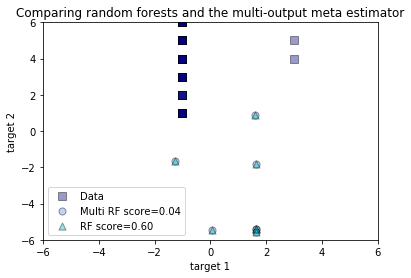

In [78]:
plt.figure()
s = 50
a = 0.4
plt.scatter(y_test[y_test.columns[0]], y_test[y_test.columns[1]], edgecolor='k',
            c="navy", s=s, marker="s", alpha=a, label="Data")
plt.scatter(y_pred_multi[:, 0], y_pred_multi[:, 1], edgecolor='k',
            c="cornflowerblue", s=s, alpha=a,
            label="Multi RF score=%.2f" % multi_reg.score(X_test, y_test))
plt.scatter(y_pred[:, 0], y_pred[:, 1], edgecolor='k',
            c="c", s=s, marker="^", alpha=a,
            label="RF score=%.2f" % reg.score(X_test, y_test))
plt.xlim([-6, 6])
plt.ylim([-6, 6])
plt.xlabel("target 1")
plt.ylabel("target 2")
plt.title("Comparing random forests and the multi-output meta estimator")
plt.legend()
plt.show()

In [79]:
reg.score(X_test, y_test)

0.6001321544597881

In [80]:
reg.intercept_

array([-6.05165297e+00, -8.82341517e+04])

In [81]:
reg.coef_

array([[ 4.77056306e-03,  6.92993596e-03, -2.90873198e-04,
         8.95141516e-02,  6.62238643e-02, -2.52731492e-01,
         9.44668395e-02,  2.02906269e-03,  3.35676058e-04,
         2.44052737e-02,  6.06279063e-02,  5.01859574e-04,
        -1.64615466e-02, -3.88379644e-03, -7.08298050e-04,
        -2.54599366e-03, -7.31212386e-04, -2.85684516e-03,
         4.13072901e-03, -1.70894560e-03, -1.55912737e-04,
        -2.97894330e-03,  2.20097876e-03, -2.13777624e-03,
         8.50849922e-04, -2.17894265e+00,  2.17894265e+00,
        -5.59873964e-02, -1.32632595e-01,  1.88619991e-01,
        -2.43990168e+00,  1.22781235e+00,  1.21208933e+00],
       [ 4.39276461e+01,  8.12470006e+01,  7.40158754e+00,
        -1.47701874e+03, -6.62938551e+02,  2.96476076e+03,
         1.35064933e+03,  7.34531978e+00, -1.41362465e+00,
         5.25916217e+01, -1.01885727e+03,  3.94792494e+01,
        -6.21098598e+01,  2.37911731e+01,  4.41570825e+01,
        -6.76145346e+00,  7.99872006e-01, -2.65407913e+

In [82]:
X_test[:1]

,Year,Par Value,Yardage,From Location(Scorer),Lie,Elevation,Slope,Distance from Center,Distance from Edge,Fwy Firmness,Fwy Height,Grn Firmness,Grn Height,Rough Height,Stimp,Fwy Width 250,Fwy Width 275,Fwy Width 300,Fwy Width 325,Fwy Width 350,Actual 250 Distance,Actual 275 Distance,Actual 300 Distance,Actual 325 Distance,Actual 350 Distance,Around_the_Green_N,Around_the_Green_Y,1st_Putt_N,1st_Putt_Y,Left_Right_0,Left_Right_L,Left_Right_R,1st_Putt_0
0,2018,4,436,0,1,1,1,1793,1333,2,0.44,2,0.11,2.5,11.75,22.0,24.0,25.0,26.0,27.0,25.0,27.0,30.0,32.0,35.0,1,0,1,0,0,0,1,0


In [83]:
y_test[:1]

,To Location(Scorer),Distance to Pin
0,5,15480


In [84]:
y_pred[:1]

array([[6.37864353e+00, 2.08490782e+04]])

In [85]:
from sklearn.ensemble import RandomForestRegressor

multi_rf_reg = MultiOutputRegressor(RandomForestRegressor(n_estimators=100, max_depth=30, random_state=0))
rf_reg = RandomForestRegressor(n_estimators=100, max_depth=30, random_state=0)

multi_rf_reg.fit(X_test, y_test)
rf_reg.fit(X_test, y_test)

y_pred_multi = multi_rf_reg.predict(X_test)
y_pred = rf_reg.predict(X_test)

print(multi_rf_reg.score(X_test, y_test))
print(rf_reg.score(X_test, y_test))

0.9804229540352183
0.9942496046509453


In [86]:
import pickle
pickle.dump(rf_reg, open('./models/phil-mickelson-stroke.pkl', 'wb'))

In [90]:
y_test[:1]

,To Location(Scorer),Distance to Pin
0,5,15480


In [91]:
y_pred[:1]

array([[5.030000e+00, 1.559232e+04]])

In [110]:
y_pred_multi[:1]

array([[5.120000e+00, 1.560348e+04]])

In [109]:
# TODO
# - calculate the linear difficulty for each From Location and weight appropriately
# - split regression of distance to pin and To location classifier into seperate models?
# - test one hole from tee to finish to see if predict runs true (test hole outs)
# - reduce dimensionality (remove year, tourn #, player #?, course #, round, hole, shot, time, 
#   one par, scorecard yrd, actual yrd, shot type, recovery shot)
# - add starting distance to hole, and predict ending distance to hole


In [89]:
model = pickle.load(open('./models/phil-mickelson-stroke.pkl', 'rb'))

In [93]:
X_test.columns

Index(['Year', 'Par Value', 'Yardage', 'From Location(Scorer)', 'Lie',
       'Elevation', 'Slope', 'Distance from Center', 'Distance from Edge',
       'Fwy Firmness', 'Fwy Height', 'Grn Firmness', 'Grn Height',
       'Rough Height', 'Stimp', 'Fwy Width 250', 'Fwy Width 275',
       'Fwy Width 300', 'Fwy Width 325', 'Fwy Width 350',
       'Actual 250 Distance', 'Actual 275 Distance', 'Actual 300 Distance',
       'Actual 325 Distance', 'Actual 350 Distance', 'Around_the_Green_N',
       'Around_the_Green_Y', '1st_Putt_N', '1st_Putt_Y', 'Left_Right_0',
       'Left_Right_L', 'Left_Right_R', '1st_Putt_0'],
      dtype='object')

In [97]:
d1 = {
    'Year': 2019,
    'Par Value': 5,
    'Yardage': 503,
    'From Location(Scorer)': 1, # Tee Box
    'Lie': 1, # Good
    'Elevation': 1, # With
    'Slope': 1, # Level
    'Distance from Center': 329,
    'Distance from Edge': 241,
    'Fwy Firmness': 2, # Firm
    'Fwy Height': 0.36000001430511475,
    'Grn Firmness': 2, # Firm
    'Grn Height': 0.10000000149011612,
    'Rough Height': 2.25,
    'Stimp': 12.50,
    'Fwy Width 250': 28.00,
    'Fwy Width 275': 29.00,
    'Fwy Width 300': 28.00,
    'Fwy Width 325': 0.00,
    'Fwy Width 350': 0.00,
    'Actual 250 Distance': 25.00,
    'Actual 275 Distance': 28.00,
    'Actual 300 Distance': 30.00,
    'Actual 325 Distance': 0.00,
    'Actual 350 Distance': 0.00,
    'Around_the_Green_N': 1,
    'Around_the_Green_Y': 0,
    '1st_Putt_N': 1,
    '1st_Putt_Y': 0,
    'Left_Right_0': 0,
    'Left_Right_L': 1,
    'Left_Right_R': 0,
    '1st_Putt_0': 0
}
X_sim = pd.DataFrame(data=d1, index=[0])
X_sim.shape

(1, 33)

In [98]:
X_sim

,Year,Par Value,Yardage,From Location(Scorer),Lie,Elevation,Slope,Distance from Center,Distance from Edge,Fwy Firmness,Fwy Height,Grn Firmness,Grn Height,Rough Height,Stimp,Fwy Width 250,Fwy Width 275,Fwy Width 300,Fwy Width 325,Fwy Width 350,Actual 250 Distance,Actual 275 Distance,Actual 300 Distance,Actual 325 Distance,Actual 350 Distance,Around_the_Green_N,Around_the_Green_Y,1st_Putt_N,1st_Putt_Y,Left_Right_0,Left_Right_L,Left_Right_R,1st_Putt_0
0,2019,5,503,1,1,1,1,329,241,2,0.36,2,0.1,2.25,12.5,28.0,29.0,28.0,0.0,0.0,25.0,28.0,30.0,0.0,0.0,1,0,1,0,0,1,0,0


In [101]:
y_sim_pred = model.predict(X_sim)
y_sim_pred

array([[3.24000e+00, 7.09588e+03]])

In [100]:
# Location 3
# Distance 7095.88 (198 yards)
# Actual Location 5
# Actual Distance 7416 inches (206 yards)

In [106]:
print('Predicted Location', round(y_sim_pred[0][0], 0))
print('Predicted Distance to Pin', round(y_sim_pred[0][1] / 36.0, 0))

Predicted Location 3.0
Predicted Distance to Pin 197.0


##### Phil Mickelson - 2019 Genesis Open, Round 1, Hole 1
Shot 5 in the hole

Shot 4 putt 13 ft 5 in., 2 ft 11 in. to hole

Shot 3 65 ft 1 in. to green, 10 ft 3 in. to hole

Shot 2 182 yds to front center green side bunker, 74 ft 11 in. to hole

Shot 1 307 yds to left rough, 206 yds to hole


In [107]:
# using actual result to predict result of 2nd shot
d2 = {
    'Year': 2019,
    'Par Value': 5,
    'Yardage': 503,
    'From Location(Scorer)': 5, # Primary Rough
    'Lie': 0, # UNKNOWN
    'Elevation': 0, # UNKNOWN
    'Slope': 0, # UNKNOWN
    'Distance from Center': float('nan'), # UNKNOWN
    'Distance from Edge': float('nan'), # UNKNOWN
    'Fwy Firmness': 2, # Firm
    'Fwy Height': 0.36000001430511475,
    'Grn Firmness': 2, # Firm
    'Grn Height': 0.10000000149011612,
    'Rough Height': 2.25,
    'Stimp': 12.50,
    'Fwy Width 250': 28.00,
    'Fwy Width 275': 29.00,
    'Fwy Width 300': 28.00,
    'Fwy Width 325': 0.00,
    'Fwy Width 350': 0.00,
    'Actual 250 Distance': 25.00,
    'Actual 275 Distance': 28.00,
    'Actual 300 Distance': 30.00,
    'Actual 325 Distance': 0.00,
    'Actual 350 Distance': 0.00,
    'Around_the_Green_N': 1,
    'Around_the_Green_Y': 0,
    '1st_Putt_N': 1,
    '1st_Putt_Y': 0,
    'Left_Right_0': 0,
    'Left_Right_L': 1,
    'Left_Right_R': 0,
    '1st_Putt_0': 0
}
X_sim = pd.DataFrame(data=d2, index=[0])
X_sim

,Year,Par Value,Yardage,From Location(Scorer),Lie,Elevation,Slope,Distance from Center,Distance from Edge,Fwy Firmness,Fwy Height,Grn Firmness,Grn Height,Rough Height,Stimp,Fwy Width 250,Fwy Width 275,Fwy Width 300,Fwy Width 325,Fwy Width 350,Actual 250 Distance,Actual 275 Distance,Actual 300 Distance,Actual 325 Distance,Actual 350 Distance,Around_the_Green_N,Around_the_Green_Y,1st_Putt_N,1st_Putt_Y,Left_Right_0,Left_Right_L,Left_Right_R,1st_Putt_0
0,2019,5,503,5,0,0,0,NaN,NaN,2,0.36,2,0.1,2.25,12.5,28.0,29.0,28.0,0.0,0.0,25.0,28.0,30.0,0.0,0.0,1,0,1,0,0,1,0,0


In [108]:
y_sim_pred = model.predict(X_sim)
y_sim_pred

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').